# Setup

## Import

In [1]:
from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

from obspy.geodetics import gps2dist_azimuth, locations2degrees
from obspy import UTCDateTime

from dataclasses import dataclass
from typing import List
import logging
from scipy.fft import fft, fftfreq
from multiprocessing import process
import sys

print("PyFK and other classes imported successfully!")

PyFK and other classes imported successfully!


## Modify parameters

In [2]:
@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # MODIFY: Main parameters
    source_depths = np.array([15, 35, 65])
    receiver_distances = np.arange(200, 2001, 100)
    
    # MODIFY: Source parameters
    magnitude = 6
    strike = 0
    dip = 45
    rake = 90
    azimuth = 22.5

    # MODIFY: GF parameters
    npt = 5100
    dt = .1
    
    # MODIFY: Filtering parameters (Try [0.02-0.1] [0.05-0.2] [0.1-0.5] [0.2-1] [0.5-2][1-5])
    Sn_freqmin = 0.1 # for SnLg # Use 2.12 for Axel
    Sn_freqmax = 0.5 # for SnLg # Use 4.25 for Axel
    Lg_freqmin = 0.1 # for SnLg # Use 1 for Axel
    Lg_freqmax = 0.5 # for SnLg # Use 5 for Axel
    plot_freqmin = 0.1 # for synthetic plotting
    plot_freqmax = 0.5 # for synthetic plotting
    plot_corners = 4 # for synthetic plotting

    # Additional parameters
    vsm=4.7 # for SnLg, theta
    vsc=3.7 # for SnLg, theta
    moho=[30.0] # for SnLg
    sync_origintime = UTCDateTime('2021-04-28T02:21:26.196000Z') # arbitrary
    sync_longitude = -122.168861 # arbitrary
    sync_latitude = 37.428230 # arbitrary
    baz = (azimuth + 180) % 360 # auto-calculated

    # Model parameters
    layer1_thickness = 15.1
    layer1_vp =  5.80000
    layer1_vs = 3.20000
    layer1_rho = 2.60000
    layer1_q1 = 1456.0
    layer1_q2 = 600.0

    layer2_thickness = 14.9
    layer2_vp = 6.80000
    layer2_vs = 3.90000
    layer2_rho = 2.90000
    layer2_q1 = 1350.0
    layer2_q2 = 600.0
    # MOHO reached (depth 30)

    layer3_thickness = 10
    layer3_vp = 8.11061
    layer3_vs = 4.49094
    layer3_rho = 3.38076
    layer3_q1 = 1446.0
    layer3_q2 = 600.0

    layer4_thickness = 20.00
    layer4_vp = 8.10119
    layer4_vs = 4.48486
    layer4_rho = 3.37906
    layer4_q1 = 1446.0
    layer4_q2 = 600.0

    layer5_thickness = 20.00
    layer5_vp = 8.08907
    layer5_vs = 4.47715
    layer5_rho = 3.37688
    layer5_q1 = 1447.0
    layer5_q2 = 600.0
    # Depth 80 reached

    layer6_thickness = 35.00
    layer6_vp = 8.07688
    layer6_vs = 4.46953
    layer6_rho = 3.37471
    layer6_q1 = 195.0
    layer6_q2 = 80.0

    layer7_thickness = 35.00
    layer7_vp = 8.05540
    layer7_vs = 4.45643
    layer7_rho = 3.37091
    layer7_q1 = 195.0
    layer7_q2 = 80.0
    # Depth 150 reached

    layer8_thickness = 35.00
    layer8_vp = 8.03370
    layer8_vs = 4.44361
    layer8_rho = 3.36710
    layer8_q1 = 195.0
    layer8_q2 = 80.0

    layer9_thickness = 35.00
    layer9_vp = 8.01180
    layer9_vs = 4.43108
    layer9_rho = 3.36330
    layer9_q1 = 195.0
    layer9_q2 = 80.0
    # Depth 220 reached

    layer10_thickness = 10.00
    layer10_vp = 8.55896
    layer10_vs = 4.64391
    layer10_rho = 3.43578
    layer10_q1 = 362.0
    layer10_q2 = 143.0
    # Depth 230 reached
    
    def get_mechanism(self) -> List[float]:
        return [self.magnitude, self.strike, self.dip, self.rake]

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2], 
            [self.layer5_thickness, self.layer5_vs, self.layer5_vp, self.layer5_rho, self.layer5_q1, self.layer5_q2],
            [self.layer6_thickness, self.layer6_vs, self.layer6_vp, self.layer6_rho, self.layer6_q1, self.layer6_q2], 
            [self.layer7_thickness, self.layer7_vs, self.layer7_vp, self.layer7_rho, self.layer7_q1, self.layer7_q2], 
            [self.layer8_thickness, self.layer8_vs, self.layer8_vp, self.layer8_rho, self.layer8_q1, self.layer8_q2],
            [self.layer9_thickness, self.layer9_vs, self.layer9_vp, self.layer9_rho, self.layer9_q1, self.layer9_q2],
            [self.layer10_thickness, self.layer10_vs, self.layer10_vp, self.layer10_rho, self.layer10_q1, self.layer10_q2],
        ])

# Create configuration instance
parameters = SimulationConfig()
print("Config created successfully!")
print("Source depths: ", parameters.source_depths)
print("Receiver distances: ", parameters.receiver_distances)

Config created successfully!
Source depths:  [15 35 65]
Receiver distances:  [ 200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400 1500
 1600 1700 1800 1900 2000]


## Define models

In [3]:
# Create seismic model
model_data = parameters.get_model_data()
model = SeisModel(model=model_data, flattening = True)

# Create sources array
def setup_source(parameters, i):
    """Setup a source at a given depth (i)"""
    # Create source model
    source = SourceModel(
        sdep=parameters.source_depths[i],
        srcType="dc",
        source_mechanism=parameters.get_mechanism()
    )
    print(f"Source {i}:", source)
    return source
print("Creating sources array...")
sources = []
for i in range(len(parameters.source_depths)):
    source = setup_source(parameters, i)
    sources.append(source)

# Create configs array
def setup_config(model, source, parameters):
    """Setup configuration object for a given source; with error handling"""
    try:
        
        config_obj = Config(
            model=model,
            source=source,
            npt=parameters.npt,
            dt=parameters.dt,
            receiver_distance=np.array(parameters.receiver_distances)
        )
        print(f"Config {i}:", config_obj)
        return config_obj

    except Exception as e:
        logging.error(f"Error setting up configuration: {e}")
        raise
print("Creating configs array...")
configs = []
for i in range(len(sources)):
    config_obj= setup_config(model, sources[i], parameters)
    configs.append(config_obj)

Creating sources array...
Source 0: SourceModel(sdep=15, srcType=dc, source_mechanism=[ 6  0 45 90])
Source 1: SourceModel(sdep=35, srcType=dc, source_mechanism=[ 6  0 45 90])
Source 2: SourceModel(sdep=65, srcType=dc, source_mechanism=[ 6  0 45 90])
Creating configs array...
Config 0: Config(model=SeisModel(layers=11, flattening=True), source=SourceModel(sdep=15.017685903905587, srcType=dc, source_mechanism=[ 6  0 45 90]), receiver_distance=[ 200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300.
 1400. 1500. 1600. 1700. 1800. 1900. 2000.], taper=0.3, filter=(0, 0), npt=5100, dt=0.1, dk=0.3, smth=1.0, pmin=0.0, pmax=1.0, kmax=15.0, rdep=0.0, updn=all, samples_before_first_arrival=50, suppression_sigma=2.0)
Config 1: Config(model=SeisModel(layers=11, flattening=True), source=SourceModel(sdep=35.09649231220403, srcType=dc, source_mechanism=[ 6  0 45 90]), receiver_distance=[ 200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300.
 1400. 1500. 1600. 1700. 1

# Calculate Green's functions

In [4]:
# gfs = []

# for i in range(len(configs)):
#     config = configs[i]
#     gf = calculate_gf(config)
#     gfs.append(gf)
#     print('Calculated Green\'s function for source depth: ' + str(int(parameters.source_depths[i])).zfill(2) + 'km')

# print("----------------Structure of gfs----------------")
# print("gfs is an array; length equal to # of depths: \n", (gfs))
# print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
# print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

## Read/save Green's functions

In [5]:
import os
from glob import glob
import obspy

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs) # Number of depths
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i] # Streams for given depth, one for each receiver distance
        for j in range(len(gf_w)): # Loop over stream for given depth and receiver distance
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

In [6]:
# Folder Bulk_gfs, subfolder 01, file grn_001_06 indicates 2nd depth (01, 0 index), 2nd receiver (001, 0 index), 6th trace (06, 1 index)
# saveGF('Wang_gfs', gfs)
gfs = readGF('Wang_gfs')

print("----------------Structure of gfs----------------")
print("gfs is an array; length equal to # of depths: \n", (gfs))
print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x134839e50>, <obspy.core.stream.Stream object at 0x134a568b0>, <obspy.core.stream.Stream object at 0x134ab7970>, <obspy.core.stream.Stream object at 0x134ab3e50>, <obspy.core.stream.Stream object at 0x134ac0940>, <obspy.core.stream.Stream object at 0x134ac0b50>, <obspy.core.stream.Stream object at 0x134ac96a0>, <obspy.core.stream.Stream object at 0x134accaf0>, <obspy.core.stream.Stream object at 0x134ad0cd0>, <obspy.core.stream.Stream object at 0x134ad6760>, <obspy.core.stream.Stream object at 0x134ad4b80>, <obspy.core.stream.Stream object at 0x134ae2850>, <obspy.core.stream.Stream object at 0x134ad79a0>, <obspy.core.stream.Stream object at 0x134c02c40>, <obspy.core.stream.Stream object at 0x134c0ca30>, <obspy.core.stream.Stream object at 0x134ae2ac0>, <obspy.core.stream.Stream object at 0x134c15670>, <obspy.core.stream.Stream object at 0x134c10a90>, <

# Generate STF

Half duration: 0.2 seconds
Time sigma: 0.17 seconds
Duration: 1.000 seconds
Sampling rate: 10 Hz
Number of points: 11


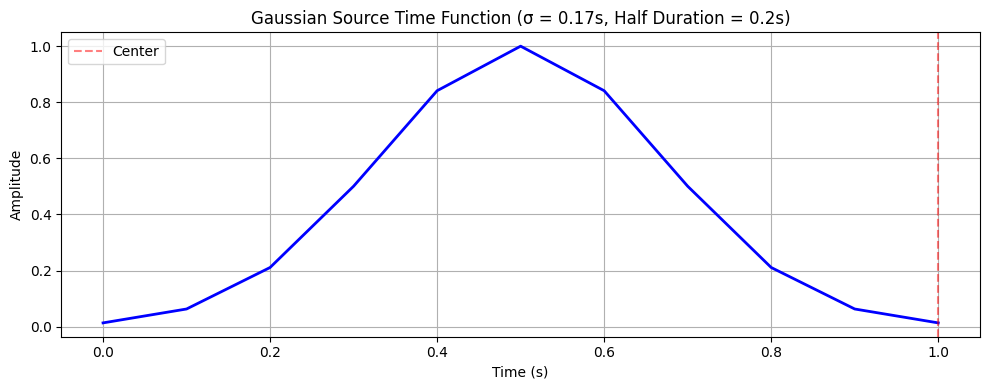

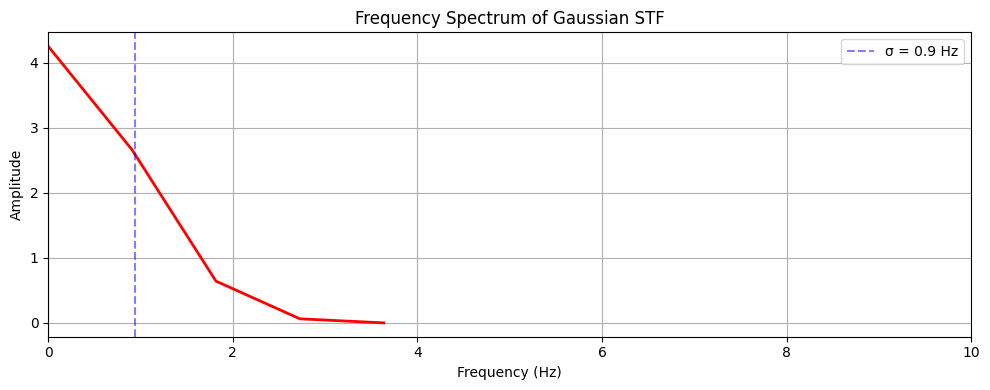

In [7]:
# # ------ Triangular
# source_time_function = generate_source_time_function(dura=dura, rise=rise, delta=delta)
# print("Source time function generated.")

import numpy as np
from obspy import Trace
import matplotlib.pyplot as plt

def generate_gaussian_stf(half_duration=0.2, sigma_time=0.17, delta=0.01, duration=1.0):
    """
    Generate a Gaussian source time function with specified half duration and standard deviation.
    
    Parameters:
    -----------
    half_duration : float = 0.2
        Half duration of the source time function (seconds)
    sigma_time : float = 0.17
        Standard deviation in time domain (seconds)
    delta : float = 0.01
        Time sampling interval (seconds)
    duration : float = 1.0
        Total duration (seconds)
    
    Returns:
    --------
    obspy.Trace
        Gaussian source time function
    """
    # Time array
    t = np.arange(0, duration + delta, delta)
    center_time = duration / 2
    
    # Generate Gaussian in time domain
    stf = np.exp(-0.5 * ((t - center_time) / sigma_time)**2)
    
    # Normalize to maximum amplitude of 1
    stf = stf / np.max(np.abs(stf))
    
    # Create ObsPy Trace
    trace = Trace(data=stf)
    trace.stats.delta = delta
    trace.stats.starttime = 0
    
    return trace

# Generate the Gaussian STF
gaussian_stf = generate_gaussian_stf(half_duration=0.2, sigma_time=0.17, delta=0.1, duration=1.0)

# Print parameters for verification
print(f"Half duration: {0.2} seconds")
print(f"Time sigma: {0.17} seconds")
print(f"Duration: {gaussian_stf.stats.endtime - gaussian_stf.stats.starttime:.3f} seconds")
print(f"Sampling rate: {1/gaussian_stf.stats.delta:.0f} Hz")
print(f"Number of points: {len(gaussian_stf.data)}")

# Plot to verify it looks Gaussian
plt.figure(figsize=(10, 4))
plt.plot(gaussian_stf.times(), gaussian_stf.data, 'b-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Gaussian Source Time Function (σ = 0.17s, Half Duration = 0.2s)')
plt.grid(True)
plt.axvline(gaussian_stf.stats.endtime - gaussian_stf.stats.starttime, color='r', linestyle='--', alpha=0.5, label='Center')
plt.legend()
plt.tight_layout()
plt.show()

# Plot frequency spectrum to verify
from scipy.fft import fft, fftfreq
freq = fftfreq(len(gaussian_stf.data), gaussian_stf.stats.delta)
spectrum = np.abs(fft(gaussian_stf.data))
spectrum = spectrum[:len(spectrum)//2]  # Only positive frequencies
freq = freq[:len(freq)//2]
plt.figure(figsize=(10, 4))
plt.plot(freq, spectrum, 'r-', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Gaussian STF')
plt.grid(True)

# Calculate corresponding frequency sigma
sigma_freq = 1.0 / (2.0 * np.pi * 0.17)
plt.axvline(sigma_freq, color='b', linestyle='--', alpha=0.5, label=f'σ = {sigma_freq:.1f} Hz')
plt.xlim(0, 10)
plt.legend()
plt.tight_layout()
plt.show()

## Plot STF with filter band

Frequencies above 10% max: 0.91 to 1.82 Hz


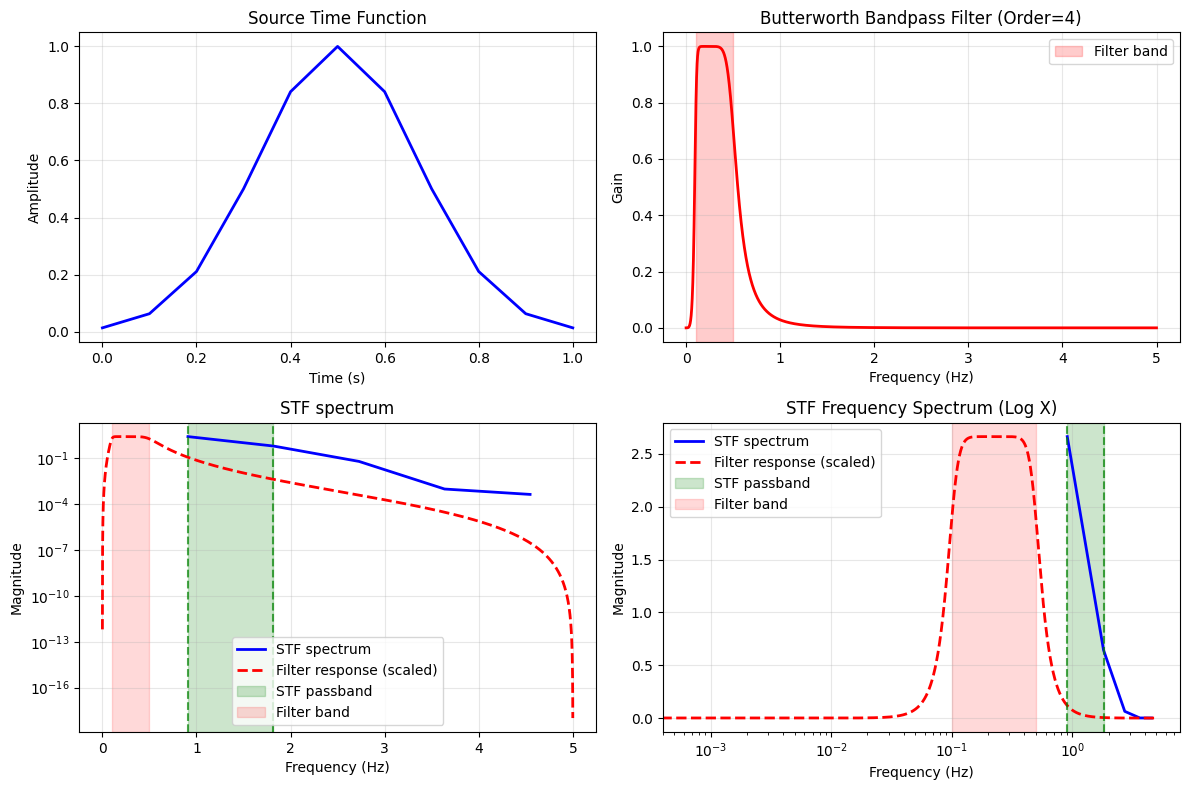

STF passband: 0.91-1.82 Hz
Filter band: 0.1-0.5 Hz


In [8]:
# Calculate frequency spectrum
n = len(gaussian_stf)  # Get the number of points in the STF
freq = fftfreq(n, 0.1)       # Create frequency axis from -Nyquist to +Nyquist (Hz)
fft_stf = fft(gaussian_stf)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)    # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold
if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = np.arange(len(gaussian_stf)) * 0.1  # Create time axis (seconds)
ax1.plot(time_stf, gaussian_stf, 'b-', linewidth=2)  # Plot STF in time domain
ax1.set_title(f'Source Time Function')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from parameters)
from scipy.signal import butter, freqz
# Filter parameters
freqmin = parameters.plot_freqmin
freqmax = parameters.plot_freqmax
corners = 4
fs = 1.0 / parameters.dt  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()


# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {freqmin}-{freqmax} Hz")

# Calculate synthetics

In [9]:
sync_results = []
for i in range(len(gfs)): # loop over depths
    sync_result = calculate_sync(gfs[i], configs[i], parameters.azimuth, gaussian_stf) # calculate sync for given depth, all receivers
    sync_results.append(sync_result)
    print(f"Calculated synthetic seismograms for depth {i}: {sync_result}")

print("----------------Structure of sync_results----------------")
print("sync_results is an array; length equal to # of depths: \n", sync_results)
print("sync_results[0] are the streams for 1st depth; length equal to # of receivers: \n", sync_results[0])
print("sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: \n", sync_results[0][0]) 

for i in range(len(sync_results)):
    for j in range(len(sync_results[i])):
        selected_sync = sync_results[i][j] # stream for given depth (i) and receiver distance (j)
        # Assign channel codes to synthetic traces (Z, R, T components)
        channel_codes = ['BHZ', 'BHR', 'BHT'] 
        for k, tr in enumerate(selected_sync):
            tr.stats.channel = channel_codes[k]
        # Set synthetic trace to start at correct time (accounting for shift)
        for tr in selected_sync:
            tr.stats.starttime = parameters.sync_origintime + tr.stats.sac.b
            tr.stats.sac.o = -tr.stats.sac.b

Calculated synthetic seismograms for depth 0: [<obspy.core.stream.Stream object at 0x145a0bdc0>, <obspy.core.stream.Stream object at 0x145a0e790>, <obspy.core.stream.Stream object at 0x145a0ed90>, <obspy.core.stream.Stream object at 0x145a144f0>, <obspy.core.stream.Stream object at 0x145a14c10>, <obspy.core.stream.Stream object at 0x145a17370>, <obspy.core.stream.Stream object at 0x145a17a90>, <obspy.core.stream.Stream object at 0x145a1a1f0>, <obspy.core.stream.Stream object at 0x145a1a910>, <obspy.core.stream.Stream object at 0x145a1c070>, <obspy.core.stream.Stream object at 0x145a1c790>, <obspy.core.stream.Stream object at 0x145a1cee0>, <obspy.core.stream.Stream object at 0x145a20610>, <obspy.core.stream.Stream object at 0x145a20d30>, <obspy.core.stream.Stream object at 0x145a22490>, <obspy.core.stream.Stream object at 0x145a22bb0>, <obspy.core.stream.Stream object at 0x145a25310>, <obspy.core.stream.Stream object at 0x145a25a30>, <obspy.core.stream.Stream object at 0x145a28190>]
Cal

# Run SnLg on synthetics

In [10]:
sys.path.append("/Users/emmanuelzheng/Downloads/Synthetics")

# --- 1. Imports ---
from SnLg.snlg_analyses_old import SnLg_Analyses, SnLg_OneEventStationPair
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import copy

# --- 2. Prepare synthetic waveforms ---
sync_SnLg = copy.deepcopy(sync_results)
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):
        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        selected_sync.rotate('RT->NE', back_azimuth=parameters.baz) # rotate to ZNE

# --- BEGIN CALCULATING SnLg FOR ALL WAVEFORMS AT THIS POINT ---
results = []
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):

        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        depth = parameters.source_depths[i]
        receiver_distance = parameters.receiver_distances[j]

        # --- 3. Prepare event data ---
        from collections import namedtuple
        Event = namedtuple('Event', ['event_lat', 'event_lon', 'event_dep', 'event_time', 'event_mag'])
        event = Event(
            event_lat=parameters.sync_latitude,
            event_lon=parameters.sync_longitude,
            event_dep=depth,
            event_time=parameters.sync_origintime,
            event_mag=parameters.magnitude
        )

        # --- 4. Calculate other required parameters ---
        gcarc = kilometer2degrees(receiver_distance)
        model = TauPyModel(model="iasp91")
        arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=gcarc, phase_list=['p', 'P'])
        p_arrival = event.event_time + arrivals[0].time if arrivals else None

        # --- 5. Create the SnLg_Analyses objects ---
        snlg_analyzer = SnLg_Analyses(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=parameters.vsm,
            vsc=parameters.vsc,
            moho=parameters.moho,
            sn_filt=(parameters.Sn_freqmin, parameters.Sn_freqmax),
            lg_filt=(parameters.Lg_freqmin, parameters.Lg_freqmax)
        )
        snlg_analyzer.snlg_onepair = SnLg_OneEventStationPair(
            event=event,
            station=None,
        )

        # --- 6. Run the analysis on synthetic stream ---
        snlg_analyzer.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.baz)

        # --- 7. Get the results from synthetic stream ---
        print("---------Stats for depth", depth, "and receiver distance", receiver_distance, "---------")
        print("Sn/Lg raw ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_raw)
        print("Sn/Lg corrected ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_cor)
        print("Sn window:", snlg_analyzer.snlg_onepair.sn_window)
        print("Lg window:", snlg_analyzer.snlg_onepair.lg_window)
        print("Sn amplitude:", snlg_analyzer.snlg_onepair.amp_sn)
        print("Lg amplitude:", snlg_analyzer.snlg_onepair.amp_lg)

        # --- 8. Save the results as a tuple ---
        result_new= (depth, receiver_distance, snlg_analyzer.snlg_onepair.SnRLg_raw, snlg_analyzer.snlg_onepair.SnRLg_cor, snlg_analyzer.snlg_onepair.sn_window, snlg_analyzer.snlg_onepair.lg_window, snlg_analyzer.snlg_onepair.amp_sn, snlg_analyzer.snlg_onepair.amp_lg)
        results.append(result_new)

# # --- 9. Save the results as a pandas DataFrame ---
# results_df = pd.DataFrame(results, columns=['depth', 'receiver_distance', 'SnRLg_raw', 'SnRLg_cor', 'sn_window', 'lg_window'])
# results_df.to_csv('results.csv', index=False)

/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------Stats for depth 15 and receiver distance 200 ---------
Sn/Lg raw ratio (ln): -2.868939873955683
Sn/Lg corrected ratio (ln): -2.6962459919811295
Sn window: (44.75552838087985, 52.587745847533824)
Lg window: (53.22039056883338, 67.41249472052228)
Sn amplitude: 0.0722212053062731
Lg amplitude: 1.27241707465419
---------Stats for depth 15 and receiver distance 300 ---------
Sn/Lg raw ratio (ln): -3.139993310096986
Sn/Lg corrected ratio (ln): -3.0248640554472837
Sn window: (66.0321241255607, 77.58774584753382)
Lg window: (79.3411233246386, 100.4987562112089)
Sn amplitude: 0.026600504239090456
Lg amplitude: 0.6145703968847178
---------Stats for depth 15 and receiver distance 400 ---------
Sn/Lg raw ratio (ln): -3.1345731051447903
Sn/Lg corrected ratio (ln): -3.077008477819939
Sn window: (87.30871987024155, 102.58774584753382)
Lg window: (105.55879536911358, 133.70780746754386)
Sn amplitude: 0.013963115608883435
Lg amplitude: 0.32085597894574625
---------Stats for depth 15 and receiv

## Plot some synthetics for verification

In [11]:
def process_component(component, parameters):
    """Process a single component with standard filtering"""
    processed_component = component.copy()
    processed_component.detrend("linear")
    processed_component.taper(max_percentage=0.05, type='hann')
    processed_component.filter("bandpass", freqmin=parameters.plot_freqmin, freqmax=parameters.plot_freqmax, 
                         corners=parameters.plot_corners, zerophase=True)
    return processed_component

def find_result(depth, receiver_distance, results):
    for result in results:
        if result[0] == depth and result[1] == receiver_distance:
            return result
    return None

Synthetic 1 ln(Sn/Lg): -3.2596344426515613
Synthetic 2 ln(Sn/Lg): -1.3547700410000718


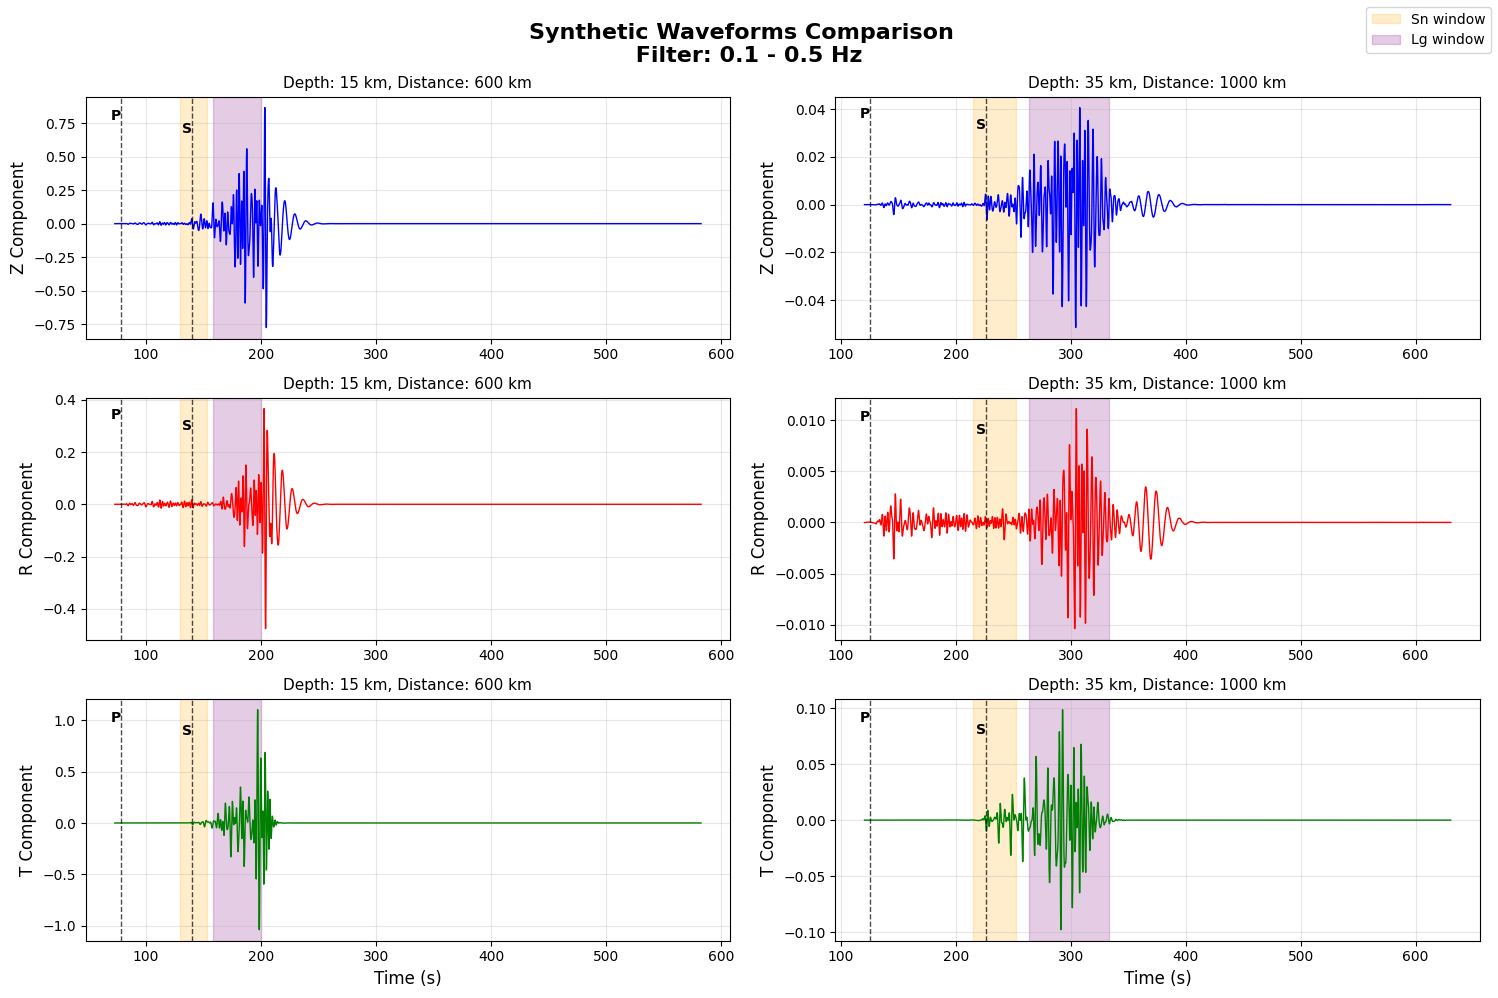

In [12]:
# MODIFY to choose synthetics
# Synthetic 1
depth_index_1 = 0
receiver_index_1 = 4
# Synthetic 2  
depth_index_2 = 1
receiver_index_2 = 8

# Get the corresponding depth and distance values
depth_1 = parameters.source_depths[depth_index_1]
receiver_distance_1 = parameters.receiver_distances[receiver_index_1]
depth_2 = parameters.source_depths[depth_index_2]
receiver_distance_2 = parameters.receiver_distances[receiver_index_2]

# Get the streams and SnLg info for these combinations
stream_1 = sync_results[depth_index_1][receiver_index_1]
stream_2 = sync_results[depth_index_2][receiver_index_2]
result_1 = find_result(depth_1, receiver_distance_1, results)
result_2 = find_result(depth_2, receiver_distance_2, results)

# Create the plot
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle(f'Synthetic Waveforms Comparison \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz', fontsize=16, fontweight='bold')

# Component names and colors
components = ['Z', 'R', 'T']
colors = ['blue', 'red', 'green']

for i, (component, color) in enumerate(zip(components, colors)):
    # Left column - Synthetic 1
    ax_left = axes[i, 0]
    trace_1 = process_component(stream_1[i], parameters)
    time_1 = np.arange(len(trace_1)) * trace_1.stats.delta + trace_1.stats.sac.b
    ax_left.plot(time_1, trace_1.data, color=color, linewidth=1)
    ax_left.set_ylabel(f'{component} Component', fontsize=12)
    ax_left.grid(True, alpha=0.3)
    ax_left.set_title(f'Depth: {depth_1} km, Distance: {receiver_distance_1} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_1:
        sn_window, lg_window = result_1[4], result_1[5]
        if sn_window:
            ax_left.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2, label='Sn window' if i == 0 else "")
        if lg_window:
            ax_left.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2, label='Lg window' if i == 0 else "")
    # Add P and S arrivals
    if hasattr(trace_1.stats, 'sac'):
        p_time = getattr(trace_1.stats.sac, 't1', None)
        s_time = getattr(trace_1.stats.sac, 't2', None)
        if p_time is not None and p_time != -12345:
            ax_left.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
            ax_left.text(p_time, ax_left.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                        horizontalalignment='right', verticalalignment='top')
        if s_time is not None and s_time != -12345:
            ax_left.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
            ax_left.text(s_time, ax_left.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                        horizontalalignment='right', verticalalignment='top')

    # Right column - Synthetic 2
    ax_right = axes[i, 1]
    trace_2 = process_component(stream_2[i], parameters)
    time_2 = np.arange(len(trace_2)) * trace_2.stats.delta + trace_2.stats.sac.b
    ax_right.plot(time_2, trace_2.data, color=color, linewidth=1)
    ax_right.set_ylabel(f'{component} Component', fontsize=12)
    ax_right.grid(True, alpha=0.3)
    ax_right.set_title(f'Depth: {depth_2} km, Distance: {receiver_distance_2} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_2:
        sn_window, lg_window = result_2[4], result_2[5]
        if sn_window:
            ax_right.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2)
        if lg_window:
            ax_right.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2)
    # Add P and S arrivals
    if hasattr(trace_2.stats, 'sac'):
        p_time = getattr(trace_2.stats.sac, 't1', None)
        s_time = getattr(trace_2.stats.sac, 't2', None)
        if p_time is not None and p_time != -12345:
            ax_right.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
            ax_right.text(p_time, ax_right.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                        horizontalalignment='right', verticalalignment='top')
        if s_time is not None and s_time != -12345:
            ax_right.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
            ax_right.text(s_time, ax_right.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                        horizontalalignment='right', verticalalignment='top')

# Set x-axis labels for the bottom subplots
axes[-1, 0].set_xlabel('Time (s)', fontsize=12)
axes[-1, 1].set_xlabel('Time (s)', fontsize=12)

# Add legends only to the first row to avoid duplicates
handles, labels = [], []
for ax in [axes[0, 0], axes[0, 1]]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
if handles:
    fig.legend(handles, labels, loc='upper right')

print('Synthetic 1 ln(Sn/Lg):', result_1[2]) # index 2 is raw, 3 is cor
print('Synthetic 2 ln(Sn/Lg):', result_2[2])

plt.tight_layout()
plt.show()


## Plot synthetics versus depth

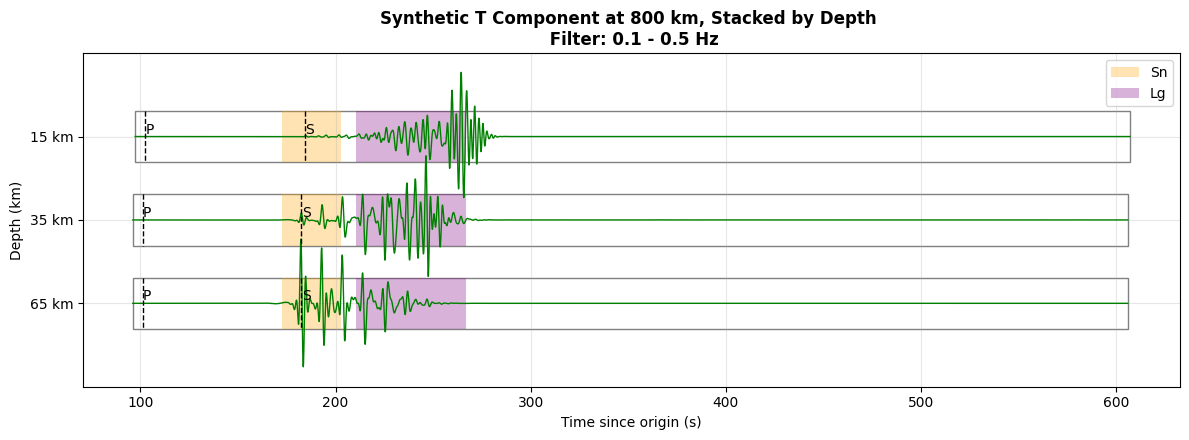

In [13]:
# MODIFY to choose receiver distance
receiver_index = 6

n_depths = len(sync_results)
trace_height = 1.3  # vertical space per trace
box_height = 0.8    # height of the box around each trace
fig, ax = plt.subplots(figsize=(12, 1.5 * n_depths))
sn_label_added = False
lg_label_added = False

for depth_idx in range(n_depths):
    # print(f"Depth: {parameters.source_depths[depth_idx]} km, Receiver: {parameters.receiver_distances[receiver_index]} km")
    stream = sync_results[depth_idx][receiver_index]
    tr = process_component(stream[-1], parameters)  # T component is last in stream
    t = np.arange(tr.stats.npts) * tr.stats.delta + tr.stats.sac.b
    data = tr.data / np.max(np.abs(tr.data))
    y_base = depth_idx * trace_height
    y_bottom = y_base - box_height/2

    # Draw the main rectangle for this trace
    rect = Rectangle(
        (t[0], y_bottom),
        t[-1] - t[0],
        box_height,
        linewidth=1, edgecolor='gray', facecolor='none', zorder=0
    )
    ax.add_patch(rect)

    # Highlight Sn/Lg windows as filled rectangles within the box
    result = find_result(parameters.source_depths[depth_idx], parameters.receiver_distances[receiver_index], results)
    if result:
        sn_window, lg_window = result[4], result[5]
        if sn_window:
            sn_rect = Rectangle(
                (sn_window[0], y_bottom),
                sn_window[1] - sn_window[0],
                box_height,
                linewidth=0, facecolor='orange', alpha=0.3, zorder=1,
                label='Sn' if not sn_label_added else None
            )
            ax.add_patch(sn_rect)
            sn_label_added = True
        if lg_window:
            lg_rect = Rectangle(
                (lg_window[0], y_bottom),
                lg_window[1] - lg_window[0],
                box_height,
                linewidth=0, facecolor='purple', alpha=0.3, zorder=1,
                label='Lg' if not lg_label_added else None
            )
            ax.add_patch(lg_rect)
            lg_label_added = True

    # Plot the trace, vertically offset
    ax.plot(t, data + y_base, color='green', linewidth=1, zorder=2)

    # Mark P and S arrivals as vertical lines spanning the box
    if hasattr(tr.stats, 'sac'):
        b = tr.stats.sac.b if hasattr(tr.stats.sac, 'b') else 0.0
        t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
        t2 = tr.stats.sac.t2 if hasattr(tr.stats.sac, 't2') else None
        if t1 is not None and t1 != -12345:
            ax.vlines(t1, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
            ax.text(t1 + .3, y_base, 'P', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
        if t2 is not None and t2 != -12345:
            ax.vlines(t2, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
            ax.text(t2 + .3, y_base, 'S', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
    
    # Verify P arrival time
    # for depth_idx in range(n_depths):
    #     stream = sync_results[depth_idx][receiver_index]
    #     tr = stream[-1]
    #     t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
    #     print(f"Depth {parameters.source_depths[depth_idx]} km: P arrival (t1) = {t1}")

# Set y-limits to fit all traces with a little padding
ax.set_ylim(-trace_height, n_depths * trace_height)
ax.set_yticks([i * trace_height for i in range(n_depths)])
ax.set_yticklabels([f"{d} km" for d in parameters.source_depths])
ax.invert_yaxis()  # Depth increases downward

ax.set_xlabel("Time since origin (s)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Synthetic T Component at {parameters.receiver_distances[receiver_index]} km, Stacked by Depth \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz", fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Plot results

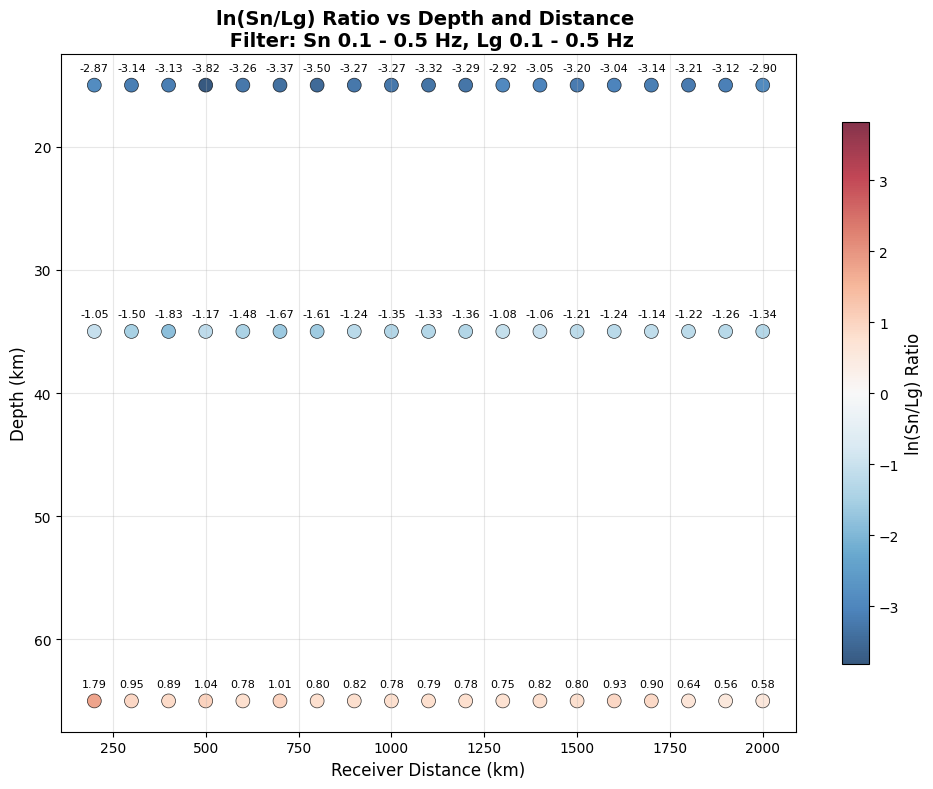

Total data points: 57
Valid ratios: 57
Missing ratios: 0


In [14]:
# Extract data for plotting
depths = []
receiver_distances = []
ratios = []
sn_amps = []
lg_amps = []

for result in results:
    depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg = result
    depths.append(depth)
    receiver_distances.append(receiver_distance)
    ratios.append(snlg_raw) # use raw or cor
    sn_amps.append(amp_sn)
    lg_amps.append(amp_lg)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Separate data points with valid ratios and None ratios
valid_indices = [i for i, ratio in enumerate(ratios) if ratio is not None]
none_indices = [i for i, ratio in enumerate(ratios) if ratio is None]

# Plot valid ratio points with color mapping
if valid_indices:
    valid_depths = [depths[i] for i in valid_indices]
    valid_distances = [receiver_distances[i] for i in valid_indices]
    valid_ratios = [ratios[i] for i in valid_indices]
    
    # Create scatter plot with color mapping
    scatter = ax.scatter(valid_distances, valid_depths, 
                        c=valid_ratios, 
                        cmap='RdBu_r',  # Red-Blue diverging colormap (red=high, blue=low)
                        s=100,  # Marker size
                        edgecolors='black',  # Black edges
                        linewidth=0.5,
                        alpha=0.8,
                        vmin=-max(abs(min(valid_ratios)), abs(max(valid_ratios))),  # Set symmetric range
                        vmax=max(abs(min(valid_ratios)), abs(max(valid_ratios))))   # Set symmetric range 
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('ln(Sn/Lg) Ratio', fontsize=12)
    # Label each valid point with its ratio value
    for x, y, ratio in zip(valid_distances, valid_depths, valid_ratios):
        ax.text(x, y - 1, f"{ratio:.2f}", fontsize=8, ha='center', va='bottom', color='black')

# Plot None ratio points in gray
if none_indices:
    none_depths = [depths[i] for i in none_indices]
    none_distances = [receiver_distances[i] for i in none_indices]
    
    ax.scatter(none_distances, none_depths, 
              c='gray', 
              s=100, 
              edgecolors='black',
              linewidth=0.5,
              alpha=0.8,
              label='No ratio available')

# Customize the plot
ax.set_xlabel('Receiver Distance (km)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_title(f'ln(Sn/Lg) Ratio vs Depth and Distance \n Filter: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total data points: {len(results)}")
print(f"Valid ratios: {len(valid_indices)}")
print(f"Missing ratios: {len(none_indices)}")

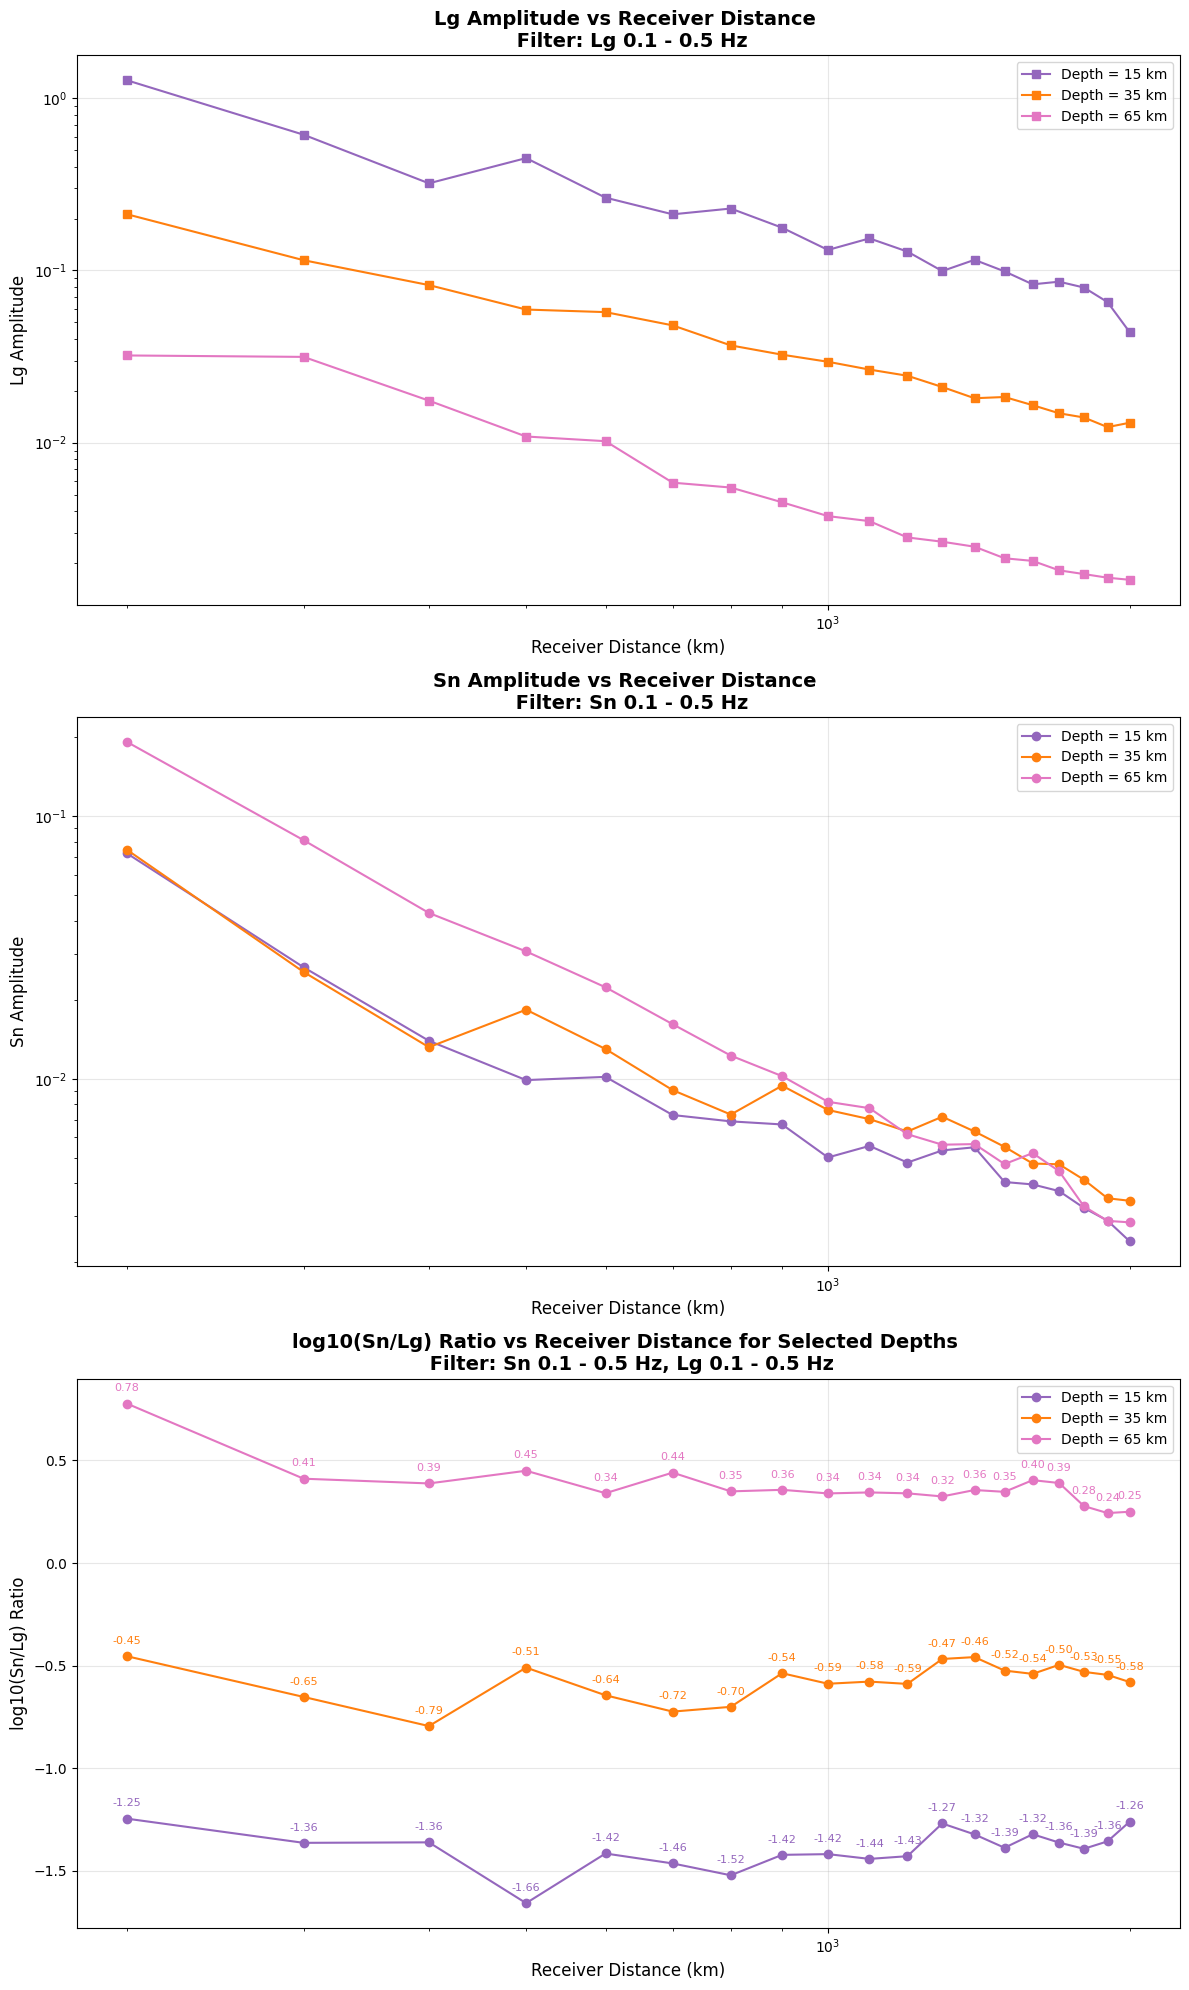

In [15]:
# Choose up to 7 depth indexes
selected_indices = [0, 1, 2] 

# Prepare data
depths = np.array(depths) # Convert arrays to numpy arrays
receiver_distances = np.array(receiver_distances)
ratios = np.array(ratios)
unique_depths = np.unique(depths) # Get unique sorted depths
selected_depths = unique_depths[selected_indices]

# Convert ln(Sn/Lg) to log10(Sn/Lg) - handle None values
ratios_log10 = [r / np.log(10) if r is not None else None for r in ratios]
ratios_log10 = np.array(ratios_log10)

# Convert lists to numpy arrays, replacing None with NaN
sn_amps_array = np.array([x if x is not None else np.nan for x in sn_amps])
lg_amps_array = np.array([x if x is not None else np.nan for x in lg_amps])

# Create the stacked plot with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))

# Color scheme: orange, purple, pink
colors = ['tab:purple', 'tab:orange', 'tab:pink']

# Plot 1: Lg amplitudes (top)
lg_plotted = False
for i, depth in enumerate(selected_depths):
    # Use np.where to get indices where both conditions are met
    indices = np.where((depths == depth) & ~np.isnan(lg_amps_array))[0]
    if len(indices) > 0:
        ax1.plot(receiver_distances[indices], lg_amps_array[indices], 
                 marker='s', linestyle='-', color=colors[i], 
                 label=f'Depth = {depth} km')
        lg_plotted = True

ax1.set_xlabel('Receiver Distance (km)', fontsize=12)
ax1.set_ylabel('Lg Amplitude', fontsize=12)
ax1.set_title(f'Lg Amplitude vs Receiver Distance \n Filter: Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
if lg_plotted:
    ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Plot 2: Sn amplitudes (middle)
sn_plotted = False
for i, depth in enumerate(selected_depths):
    # Use np.where to get indices where both conditions are met
    indices = np.where((depths == depth) & ~np.isnan(sn_amps_array))[0]
    if len(indices) > 0:
        ax2.plot(receiver_distances[indices], sn_amps_array[indices], 
                 marker='o', linestyle='-', color=colors[i], 
                 label=f'Depth = {depth} km')
        sn_plotted = True

ax2.set_xlabel('Receiver Distance (km)', fontsize=12)
ax2.set_ylabel('Sn Amplitude', fontsize=12)
ax2.set_title(f'Sn Amplitude vs Receiver Distance \n Filter: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz', fontsize=14, fontweight='bold')
if sn_plotted:
    ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')

# Plot 3: log10(Sn/Lg) Ratio (bottom)
for i, depth in enumerate(selected_depths):
    mask = (depths == depth) & (ratios_log10 != None)
    if np.any(mask):
        ax3.plot(receiver_distances[mask], ratios_log10[mask], 
                 marker='o', linestyle='-', color=colors[i], 
                 label=f'Depth = {depth} km')
        # Optionally, annotate points
        for x, y in zip(receiver_distances[mask], ratios_log10[mask]):
            ax3.text(x, y + .05, f"{y:.2f}", fontsize=8, ha='center', va='bottom', color=colors[i])

ax3.set_xlabel('Receiver Distance (km)', fontsize=12)
ax3.set_ylabel('log10(Sn/Lg) Ratio', fontsize=12)
ax3.set_title(f'log10(Sn/Lg) Ratio vs Receiver Distance for Selected Depths \n Filter: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')

plt.tight_layout()
plt.show()